# QOSF Mentorship Screening Task 2


### Author
Tony Tong

### Question
Task 2
Implement a circuit that returns |01> and |10> with equal probability.
Requirements :
The circuit should consist only of CNOTs, RXs and RYs. 
Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
Simulations must be done with sampling (i.e. a limited number of measurements per iteration) and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

#### Bonus
How to make sure you produce state |01> + |10> and not |01> - |10> ?

(Actually for more careful readers, the “correct” version of this question is posted below:
How to make sure you produce state  |01⟩  +  |10⟩  and not any other combination of |01> + e(i*phi)|10⟩ (for example |01⟩  -  |10⟩)?)

### Answer Summary
$$|\psi\rangle=\alpha|00\rangle+\beta|01\rangle+\gamma|10\rangle+\delta|11\rangle$$

$$\left|\beta\right|^{2} = \left|\gamma\right|^{2} = 0.5$$


So in order to satisfy $\left|\beta\right|^{2} = \left|\gamma\right|^{2} = 0.5$:

$$q_1 = | 0 \rangle, q_2 = | 1 \rangle$$ $$q_1 = | 1 \rangle, q_2 = | 1 \rangle$$

When measuring in Z basis:
$$\langle 0| \sigma_z  | 0 \rangle = 1$$
$$\langle 1| \sigma_z  | 1 \rangle = -1$$

#### Designing loss fucntion
Since $q_1, q_2$ cancels each other in Z basis, we can choose our loss function for the opimizing algorithm:
$$|\langle q_1| \sigma_z  | q_1 \rangle + \langle q_2| \sigma_z  | q_2 \rangle|$$

Three optimization methods will be explored with the same loss function: Rotosolve, Rotoselect [1] and QGAN [2]. 



### References
[1] M. Ostaszewski, E. Grant, and M. Benedetti, Quantum Circuit Structure Learning, ArXiv:1905.09692 [Quant-Ph] (2019).

[2] C. Zoufal, A. Lucchi, and S. Woerner, Quantum Generative Adversarial Networks for Learning and Loading Random Distributions, Npj Quantum Inf 5, 103 (2019).

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

n_wires = 2

dev = qml.device("default.qubit", wires=2)

### Rotosolve
Rotosolve will optimize a given parameters for a given circuit ansatz. The circuit ansatz chosen is made of 2 layers of single qubit Pauli-Y/X rotation and a CNOT block to entangle the 2 qubits.

In [2]:
def opt_theta(d, params, cost):
    params[d] = 0.0
    M_0 = cost(params)
    params[d] = np.pi / 2.0
    M_0_plus = cost(params)
    params[d] = -np.pi / 2.0
    M_0_minus = cost(params)
    a = np.arctan2(
        2.0 * M_0 - M_0_plus - M_0_minus, M_0_plus - M_0_minus
    )  # returns value in (-pi,pi]
    params[d] = -np.pi / 2.0 - a
    # restrict output to lie in (-pi,pi], a convention
    # consistent with the Rotosolve paper
    if params[d] <= -np.pi:
        params[d] += 2 * np.pi


# one cycle of rotosolve
def rotosolve_cycle(cost, params):
    for d in range(len(params)):
        opt_theta(d, params, cost)
    return params

In [27]:
def ansatz(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RX(params[2], wires=1)
    qml.RY(params[3], wires=0)

@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1))
    
def cost(params):
    m = circuit(params)
    return np.sum(np.abs(m[0] + m[1]))

In [16]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [17]:
def fit(init_params, n_steps, n_measurements=1000, dev=dev):
    dev.shots = n_measurements
    params_rsol = init_params.copy()
    costs_rotosolve = []

    for i in range(n_steps):
        costs_rotosolve.append(cost(params_rsol))
        params_rsol = rotosolve_cycle(cost, params_rsol)
    
    return params_rsol, costs_rotosolve

def plot_loss(n_steps, costs, titlex):
    steps = np.arange(0, n_steps)
    plt.plot(steps, costs, "o-")
    plt.title(titlex)
    plt.xlabel("cycles")
    plt.ylabel("loss")
    plt.tight_layout()
    plt.show()

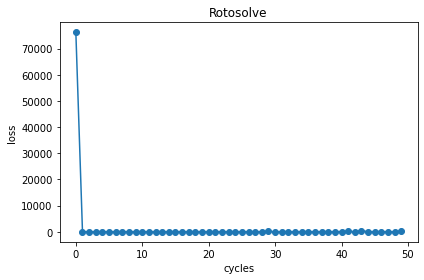

In [18]:
np.random.seed(1)
# initial parameters are randomly chosen according to a normal curve
init_params = list(get_truncated_normal(0,1,-np.pi,np.pi).rvs(4))
params_rsol, costs = fit(init_params, 50)
plot_loss(50, costs, "Rotosolve")

In [19]:
# Now we can verify the if parameters actually work 
print(params_rsol)
m = circuit(params_rsol)
np.unique(m[0] + m[1])

[2.422315693330471, 0.029203848476817562, -3.044688561872427, 0.1322316834079873]


tensor([0, 2], requires_grad=True)

In [20]:
def peek(dev=dev):
    # Take a peek at the wavefunctions (only available in simulation; not possible in real worldj)
    for i,j in enumerate(dev.state):
        print("\psi_{} = {}".format(i,j), end="\t")
        print("\prob_{} = {}".format(i,abs(j)**2))

In [21]:
peek()

\psi_0 = (-0.044755498680513275+0.005165246624681127j)	\prob_0 = 0.0020297344348352052
\psi_1 = (-0.0006535628517060404+0.3537122526043125j)	\prob_1 = 0.1251127847868181
\psi_2 = (0.933909523139567-0.00032139432585113326j)	\prob_2 = 0.8721871007050862
\psi_3 = (0.013637845386007973-0.022008844733152854j)	\prob_3 = 0.000670380073260689


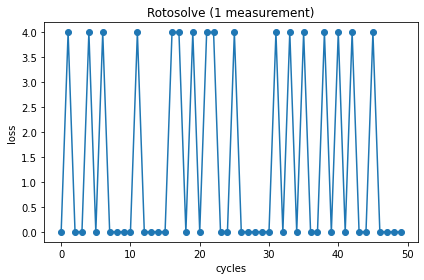

[0.0, 2.356194490192345, -0.7853981633974483, 0.7853981633974483]
\psi_0 = (0.3266407412190942+0.32664074121909414j)	\prob_0 = 0.2133883476483185
\psi_1 = (0.7885805074747375+0.13529902503654928j)	\prob_1 = 0.6401650429449554
\psi_2 = (0.13529902503654928+0.13529902503654925j)	\prob_2 = 0.036611652351681574
\psi_3 = (0.32664074121909414+0.05604269114599565j)	\prob_3 = 0.10983495705504469


In [22]:
# Now we explore how the number of measurements can affect our algorithm
# 1 measurement per step
params_rsol, costs = fit(init_params, 50, 1)
plot_loss(50, costs, "Rotosolve (1 measurement)")
print(params_rsol)
m = circuit(params_rsol)
peek()

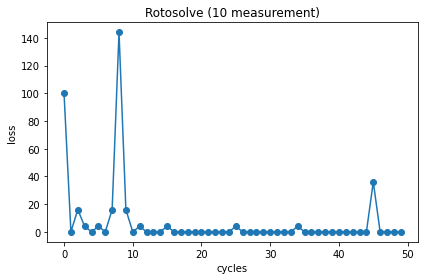

[0.540419500270584, 3.141592653589793, -3.0072712116368248, -3.0072712116368248]
\psi_0 = (1.6537124298274978e-17+0.046655745935758705j)	\prob_0 = 0.0021767586288220647
\psi_1 = (0.2700717351286718+2.856840496102952e-18j)	\prob_1 = 0.07293874211541145
\psi_2 = (-2.856840496102952e-18-0.9605767749779008j)	\prob_2 = 0.9227077406269447
\psi_3 = (-0.046655745935758705-5.881836364059869e-17j)	\prob_3 = 0.0021767586288220647


In [23]:
# 10 measurement per step
params_rsol, costs = fit(init_params, 50, 10)
plot_loss(50, costs, "Rotosolve (10 measurement)")
print(params_rsol)
m = circuit(params_rsol)
peek()

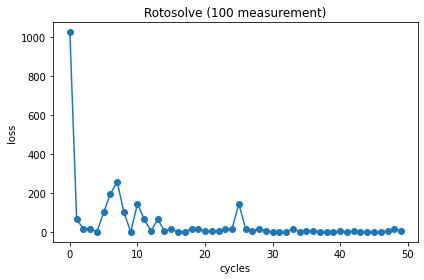

[0.7853981633974483, -0.12697278961407887, -3.0804937508108985, 0.12501182851213355]
\psi_0 = (0.004262657966617591-0.05851894986360782j)	\prob_0 = 0.0034426377460798135
\psi_1 = (-0.0002709849547632131+0.9205170377527767j)	\prob_1 = 0.8473516902259927
\psi_2 = (0.38274800527311154-0.002919509569926296j)	\prob_2 = 0.1465045590766747
\psi_3 = (-0.024331989971258464+0.045924581819448085j)	\prob_3 = 0.0027011129512526035


In [24]:
# 100 measurement per step
params_rsol, costs = fit(init_params, 50, 100)
plot_loss(50, costs, "Rotosolve (100 measurement)")
print(params_rsol)
m = circuit(params_rsol)
peek()

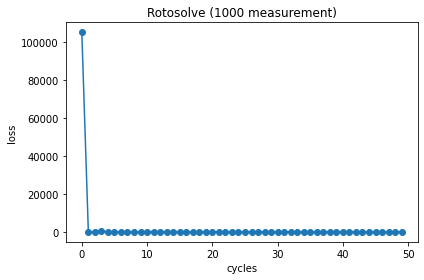

[3.141592653589793, -0.07569538218297267, -3.138094017344317, 0.01776573117072444]
\psi_0 = (-0.008876373909707398-5.879652436499561e-07j)	\prob_0 = 7.879001413063733e-05
\psi_1 = (0.00033611076010594523+1.5527617583275663e-05j)	\prob_1 = 1.1321154996680873e-07
\psi_2 = (0.9992429085933239+6.618920137779732e-05j)	\prob_2 = 0.9984863947550563
\psi_3 = (-0.03783710521370419-0.0017479955120420936j)	\prob_3 = 0.0014347020192630403


In [25]:
# 1000 measurement per step
params_rsol, costs = fit(init_params, 50, 1000)
plot_loss(50, costs, "Rotosolve (1000 measurement)")
print(params_rsol)
m = circuit(params_rsol)
peek()

The more mesurements taken per step during the optimization, the easier it is for the optimization to converge as the loss function tends to be stable after a few steps. The results also seems to be more accurate with more measurements.

### Rotoselect
Rotoselect builds on the Rotosolve algorithm, now the choice of the parametric gates themselves (Rx, Ry in our case) can also be optimized.

In [28]:
def rotosolve(d, params, generators, cost, M_0):  # M_0 only calculated once
    params[d] = np.pi / 2.0
    M_0_plus = cost(params, generators)
    params[d] = -np.pi / 2.0
    M_0_minus = cost(params, generators)
    a = np.arctan2(
        2.0 * M_0 - M_0_plus - M_0_minus, M_0_plus - M_0_minus
    )  # returns value in (-pi,pi]
    params[d] = -np.pi / 2.0 - a
    if params[d] <= -np.pi:
        params[d] += 2 * np.pi
    return cost(params, generators)


def optimal_theta_and_gen_helper(d, params, generators, cost):
    params[d] = 0.0
    M_0 = cost(params, generators)  # M_0 independent of generator selection
    for generator in ["X", "Y"]:
        generators[d] = generator
        params_cost = rotosolve(d, params, generators, cost, M_0)
        # initialize optimal generator with first item in list, "X", and update if necessary
        if generator == "X" or params_cost <= params_opt_cost:
            params_opt_d = params[d]
            params_opt_cost = params_cost
            generators_opt_d = generator
    return params_opt_d, generators_opt_d


def rotoselect_cycle(cost, params, generators):
    for d in range(len(params)):
        params[d], generators[d] = optimal_theta_and_gen_helper(d, params, generators, cost)
    return params, generators

In [29]:
def RGen(param, generator, wires):
    if generator == "X":
        qml.RX(param, wires=wires)
    elif generator == "Y":
        qml.RY(param, wires=wires)

def ansatz_rsel(params, generators):
    RGen(params[0], generators[0], wires=0)
    RGen(params[1], generators[1], wires=1)
    qml.CNOT(wires=[0, 1])
    RGen(params[2], generators[2], wires=0)
    RGen(params[3], generators[3], wires=1)

@qml.qnode(dev)
def circuit_rsel(params, generators=None):  # generators will be passed as a keyword arg
    ansatz_rsel(params, generators)
    #return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliY(1))
    return qml.sample(qml.PauliZ(0)), qml.sample(qml.PauliZ(1)) 

def cost_rsel(params, generators):
    m = circuit_rsel(params, generators=generators)
    #return np.abs(m[0] + m[1])
    return np.sum(np.abs(m[0] + m[1]))

In [35]:
def fit_select(init_params, n_steps, n_measurements=1000, dev=dev):
    dev.shots = n_measurements
    params_rsel = init_params.copy()
    costs_rsel = []
    generators = ["X", "Y", "Y", "X"]

    for i in range(n_steps):
        costs_rsel.append(cost_rsel(params_rsel, generators))
        params_rsel, generators = rotoselect_cycle(cost_rsel, params_rsel, generators)
    
    return params_rsel, costs_rsel, generators

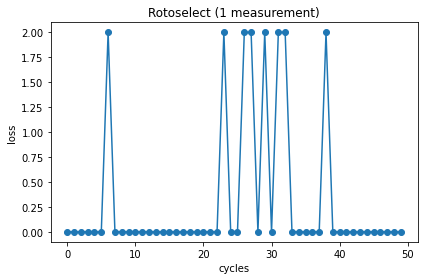

In [39]:
# Now we explore how the number of measurements can affect our algorithm
# 1 measurement per step
params_rsel, costs, generators = fit_select(init_params, 50, 1)
plot_loss(50, costs, "Rotoselect (1 measurement)")

In [41]:
print(params_rsel, generators)
peek()

[tensor(0.78539816, requires_grad=True), tensor(-1.57079633, requires_grad=True), tensor(0., requires_grad=True), tensor(-2.35619449, requires_grad=True)] ['Y', 'Y', 'Y', 'Y']
\psi_0 = (-0.35355339059327356+0j)	\prob_0 = 0.12499999999999986
\psi_1 = (-0.8535533905932737+0j)	\prob_1 = 0.7285533905932737
\psi_2 = (0.14644660940672624+0j)	\prob_2 = 0.021446609406726238
\psi_3 = (0.35355339059327373+0j)	\prob_3 = 0.12499999999999997


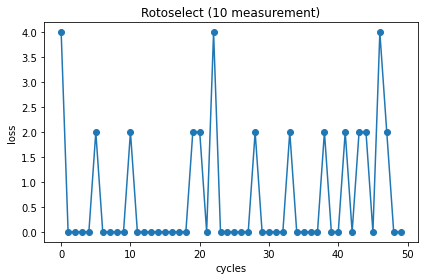

[tensor(-3.05093277, requires_grad=True), tensor(1.37340077, requires_grad=True), tensor(-0.38050638, requires_grad=True), tensor(-1.57079633, requires_grad=True)] ['Y', 'Y', 'Y', 'Y']
\psi_0 = (-0.14371365188492008+0j)	\prob_0 = 0.020653613738099992
\psi_1 = (-0.022999670363778958+0j)	\prob_1 = 0.0005289848368424921
\psi_2 = (-0.9847013375167925+0j)	\prob_2 = 0.96963672410736
\psi_3 = (-0.09581585107745688+0j)	\prob_3 = 0.009180677317697394


In [42]:
# 10 measurement per step
params_rsel, costs, generators = fit_select(init_params, 50, 10)
plot_loss(50, costs, "Rotoselect (10 measurement)")
print(params_rsel, generators)
peek()

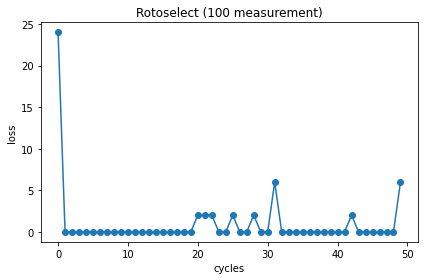

[tensor(-1.57079633, requires_grad=True), tensor(2.39513583, requires_grad=True), tensor(3.11129889, requires_grad=True), tensor(-2.27305326, requires_grad=True)] ['Y', 'X', 'Y', 'X']
\psi_0 = (-0.2577057136906907-0.00031145970974609874j)	\prob_0 = 0.06641233187597903
\psi_1 = (0.007931282025618748-0.6584259737354314j)	\prob_1 = 0.433587668124021
\psi_2 = (0.007931282025618748+0.6584259737354315j)	\prob_2 = 0.4335876681240211
\psi_3 = (0.2577057136906907-0.0003114597097461022j)	\prob_3 = 0.06641233187597903


In [43]:
# 100 measurement per step
params_rsel, costs, generators = fit_select(init_params, 50, 100)
plot_loss(50, costs, "Rotoselect (100 measurement)")
print(params_rsel, generators)
peek()

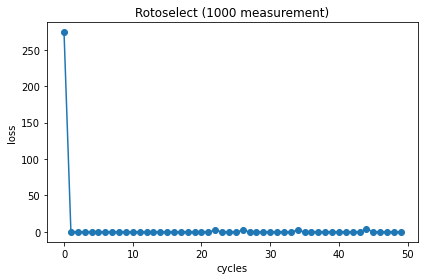

[tensor(-1.57079633, requires_grad=True), tensor(0.57658567, requires_grad=True), tensor(-3.13053783, requires_grad=True), tensor(-0.59970912, requires_grad=True)] ['Y', 'X', 'Y', 'X']
\psi_0 = (-0.018926126479280367+0.20088903405934533j)	\prob_0 = 0.04071460226880653
\psi_1 = (-0.6776607030356288-0.007833855529096129j)	\prob_1 = 0.45928539773119337
\psi_2 = (-0.6776607030356288+0.007833855529096129j)	\prob_2 = 0.45928539773119337
\psi_3 = (0.018926126479280367+0.20088903405934538j)	\prob_3 = 0.04071460226880655


In [44]:
# 1000 measurement per step
params_rsel, costs, generators = fit_select(init_params, 50, 1000)
plot_loss(50, costs, "Rotoselect (1000 measurement)")
print(params_rsel, generators)
peek()

Similar to how Rotosolve performs, Rotoselect performs with more accuracy and stability with more measurements.